In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, GlobalMaxPooling1D
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf



data = pd.read_csv('../Dataset_cleaned.csv')
data['content'] = data['content'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]','',regex=True)
label_counts = data["label"].value_counts(normalize=True) * 100
invalid_label_rows = data[~data['label'].astype(str).isin(['0', '1'])]  # 문자열로 변환 후 필터링
#토큰화한거 가지고 ㅗㅇ기기
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)



data_shuffled = data.sample(frac=1, random_state=777).reset_index(drop=True)


train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data_shuffled['content'], data_shuffled['label'], test_size=0.3, random_state=777
)  
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=2/3, random_state=777
)  

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)


maxlen = 100


x_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)


y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)
print(f"y_train shape: {y_train.shape}")
print(f"y_train[:5]: {y_train[:5]}")


print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test shape: {x_test.shape}")
print(f"Train Labels shape: {y_train.shape}, Validation Labels shape: {y_val.shape}, Test Labels shape: {y_test.shape}")
print(tokenizer.word_index)  # 결과 확인




x_train = np.array(x_train, dtype=np.int32)
x_val = np.array(x_val, dtype=np.int32)
y_train = np.array(y_train, dtype=np.float32).reshape(-1, 1)
y_val = np.array(y_val, dtype=np.float32).reshape(-1, 1)


vocab_size = max(x_train.max(), x_val.max()) + 1
 
embedding_dim = 16
maxlen = 100
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01))),  # 🔹 LSTM
    GlobalMaxPooling1D(),  
    Dense(128, activation='relu'),
    Dropout(0,3),
    Dense(1, activation='sigmoid')  
])


checkpoint_path = 'best_performed_model.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, 
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val),
    callbacks=[checkpoint],
    epochs=20, 
    verbose=2
)
model.save("best_performed_model.h5")  
m_pred = model.predict(x_test)  
pred = (m_pred > 0.5).astype(int)  
true = y_test  



print(f"True labels: {true[:10].flatten()}")  # 
print(f"Predicted labels: {pred[:10].flatten()}") 

y_train shape: (7000,)
y_train[:5]: [1 1 1 0 0]
Train shape: (7000, 100), Validation shape: (1000, 100), Test shape: (2000, 100)
Train Labels shape: (7000,), Validation Labels shape: (1000,), Test Labels shape: (2000,)
{'<OOV>': 1, 'ㅋㅋ': 2, '진짜': 3, '다': 4, '왜': 5, '너무': 6, '더': 7, '그냥': 8, '이': 9, '좀': 10, 'ㅋㅋㅋ': 11, '잘': 12, '정말': 13, '또': 14, '그': 15, '저': 16, '존나': 17, '근데': 18, '이런': 19, '난': 20, '많이': 21, '무슨': 22, 'ㅋ': 23, '참': 24, '이제': 25, '같은': 26, '하고': 27, '하는': 28, '보고': 29, '아니고': 30, '역시': 31, '사람': 32, '뭐': 33, '그리고': 34, '안': 35, '내가': 36, '수': 37, '얼마나': 38, '저런': 39, '이렇게': 40, '와': 41, '그렇게': 42, '아니라': 43, '솔직히': 44, '아니': 45, 'ㅠㅠ': 46, '이게': 47, '뭔': 48, '보면': 49, '지금': 50, '다시': 51, '그래도': 52, '요즘': 53, 'ㅎㅎ': 54, '내': 55, '돈': 56, '누가': 57, '어떻게': 58, '있는': 59, '한': 60, '좋은': 61, '없는': 62, '아': 63, '그럼': 64, '같이': 65, '하면': 66, '걍': 67, '할': 68, '꼭': 69, '제발': 70, '거': 71, 'ㅉㅉ': 72, '연기': 73, '것': 74, '여자': 75, '넘': 76, '시발': 77, '쓰레기': 78, '씨발': 79, '다른': 80, '기

c:\Users\gory4\miniforge3\envs\dataenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1: val_loss improved from inf to 0.69111, saving model to best_performed_model.weights.h5
219/219 - 8s - 38ms/step - accuracy: 0.5260 - loss: 0.7888 - val_accuracy: 0.5700 - val_loss: 0.6911
Epoch 2/20

Epoch 2: val_loss improved from 0.69111 to 0.57874, saving model to best_performed_model.weights.h5
219/219 - 6s - 27ms/step - accuracy: 0.6350 - loss: 0.6416 - val_accuracy: 0.7210 - val_loss: 0.5787
Epoch 3/20

Epoch 3: val_loss improved from 0.57874 to 0.54736, saving model to best_performed_model.weights.h5
219/219 - 6s - 27ms/step - accuracy: 0.8080 - loss: 0.4299 - val_accuracy: 0.7400 - val_loss: 0.5474
Epoch 4/20

Epoch 4: val_loss did not improve from 0.54736
219/219 - 6s - 28ms/step - accuracy: 0.8789 - loss: 0.2906 - val_accuracy: 0.7290 - val_loss: 0.6367
Epoch 5/20

Epoch 5: val_loss did not improve from 0.54736
219/219 - 6s - 26ms/step - accuracy: 0.9019 - loss: 0.2299 - val_accuracy: 0.7320 - val_loss: 0.7035
Epoch 6/20

Epoch 6: val_loss did not improve from 0.547

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✅ 예측 결과 확인
True labels: [1 1 0 1 0 0 1 1 1 1]
Predicted labels: [1 1 0 1 1 1 1 0 0 0]


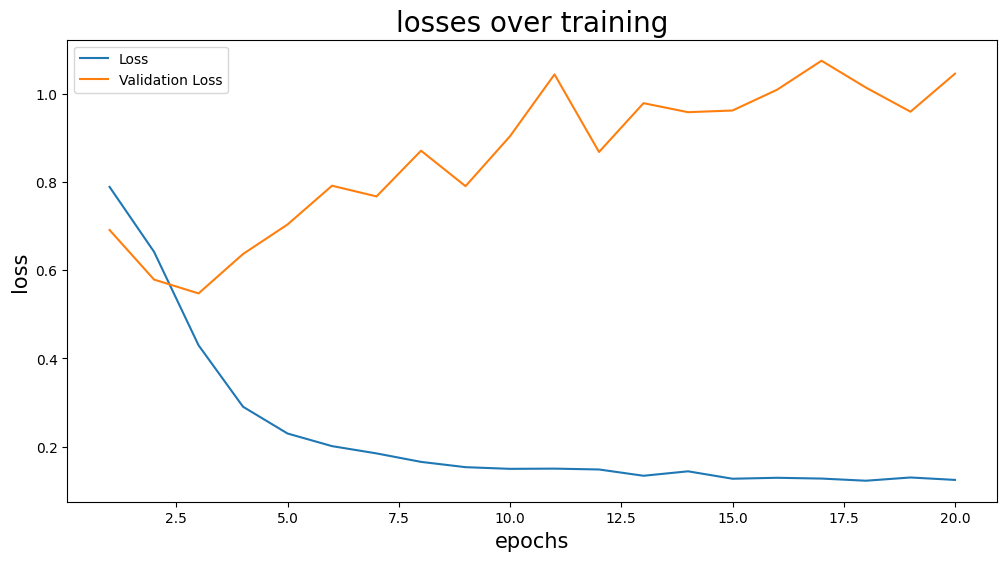

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline
model.load_weights(checkpoint_path)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(20)+1, history.history['loss'], label='Loss')
plt.plot(np.arange(20)+1, history.history['val_loss'], label='Validation Loss')
plt.title('losses over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)

plt.legend()
plt.show()

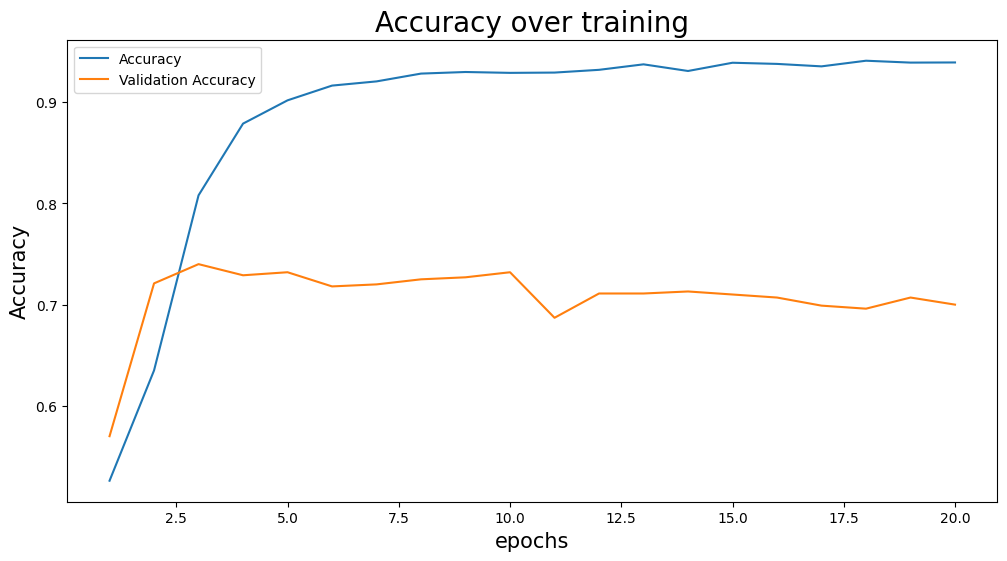

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(20)+1, history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(20)+1, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

plt.legend()
plt.show()